In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
con = sqlite3.connect(":memory:")
cur = con.cursor()

In [3]:
df_ratings = pd.read_csv("E:/git_exercise/Final/edges/rec-libimseti-dir.edges", delim_whitespace=True, skiprows=1, names=["id_from", "id_to", "rating"])

In [5]:
# создаем таблицу
df_ratings.to_sql('ratings', con, index=False, if_exists='replace')

17359346

In [6]:
# считываем  датасет info
df_info = pd.read_csv('E:/git_exercise/Final/edges/info.csv', names=["id", "gender", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])

C:\Users\albom\AppData\Local\Temp\ipykernel_4132\3540005613.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_info = pd.read_csv('E:/git_exercise/Final/edges/info.csv', names=["id", "gender", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])


In [7]:
#создаем таблицу
df_info.to_sql('info', con, index=False, if_exists='replace')

220971

In [8]:
data=pd.read_sql(
    '''
    SELECT r.id_from,i.gender gender,r.id_to, r.rating FROM info i
    join ratings r on r.id_from=i.id order by r.id_from
    ''',
    con,
)

In [9]:
data

,id_from,gender,id_to,rating
0,1,F,133,8
1,1,F,720,6
2,1,F,971,10
3,1,F,1095,7
4,1,F,1616,10
...,...,...,...,...
17359341,135359,F,215145,8
17359342,135359,F,215718,4
17359343,135359,F,218646,10
17359344,135359,F,218857,7


In [10]:
#Статистика датасета по полу
df_info['gender'].value_counts()

gender
U          83164
M          76441
F          61365
 gender        1
Name: count, dtype: int64

In [13]:
#Находим средние значения рейтинга для каждого лайкнутого пользователя
mean_ratings_to=pd.DataFrame(df_ratings.groupby('id_to')['rating'].mean())

In [14]:
# Считаем число оценок лайкнутых пользователей
mean_ratings_to['number of rating'] = pd.DataFrame(df_ratings.groupby('id_to')['rating'].count())

In [15]:
# Теперь те же два действия для лайкнувших пользователей
mean_ratings_from =pd.DataFrame(df_ratings.groupby('id_from')['rating'].mean())

In [16]:
mean_ratings_from['number of rating'] = pd.DataFrame(df_ratings.groupby('id_from')['rating'].count())

In [17]:
#Выбираем активно лайкавших пользователей (кто оценил более, например, 200 раз)
new_meanrate_from = mean_ratings_from[mean_ratings_from['number of rating'] > 200]

In [18]:
#Сохранение индексов
index_from = new_meanrate_from.index

In [19]:
# Теперь те же два действия для лайкнутых пользователей
new_meanrate_to = mean_ratings_to[mean_ratings_to['number of rating'] > 200 ]
index_to = new_meanrate_to.index

In [20]:
print(mean_ratings_from.shape, mean_ratings_to.shape)

(135359, 2) (168791, 2)


In [21]:
# Делаем сэмпл, где где 'id_from' совпадает с одним из индексов в 'index_from', и 'id_to' совпадает с одним из индексов в 'index_to'
df_ratings_sample = df_ratings.loc[(df_ratings['id_from'].isin(index_from)) & (df_ratings['id_to'].isin(index_to))]

In [22]:
df_ratings_sample.head()

,id_from,id_to,rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [23]:
df_ratings_sample.to_csv('E:/git_exercise/Final/df_sample.csv', sep=',',index=False)

In [24]:
# Сократили размер с 17+ млн до 4,7 млн записей
df_ratings_sample.shape

(5691633, 3)

In [25]:
#Уникальные id в столбцах
df_ratings_sample['id_from'].nunique(), df_ratings_sample['id_to'].nunique()

(15874, 19196)

In [26]:
#Так же, как и выше, находим средние значения и число оценок, но уже в сэмпле
mean_ratings_to = pd.DataFrame(df_ratings_sample.groupby('id_to')['rating'].mean())
mean_ratings_to['number of rating'] = pd.DataFrame(df_ratings_sample.groupby('id_to')['rating'].count())
mean_ratings_from =pd.DataFrame(df_ratings_sample.groupby('id_from')['rating'].mean())
mean_ratings_from['number of rating'] = pd.DataFrame(df_ratings_sample.groupby('id_from')['rating'].count())

Визуализация:

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

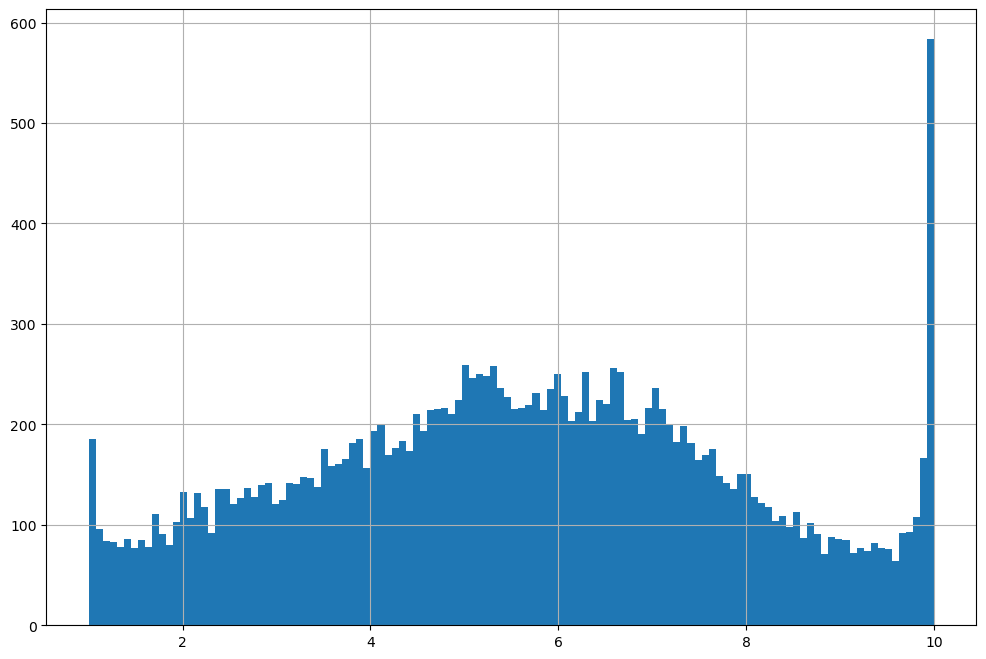

In [29]:
plt.figure(figsize=(12,8))
mean_ratings_to['rating'].hist(bins=120)

По графику, есть два пика: большое число пользователей, которых оценили по максимуму (10) и меньшее, но тоже выделяющееся - кого оценили минимально (1). Остальные, в целом, укладываются в нормальное распределение.

In [30]:
#Сортируем по убыванию
mean_ratings_to['number of rating'].sort_values(ascending=False).head()

id_to
68989     7104
83773     6959
156148    6887
179192    6426
155380    5899
Name: number of rating, dtype: int64

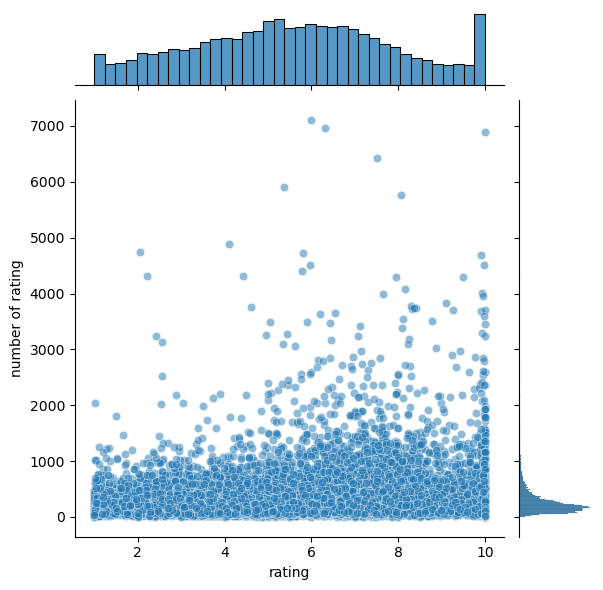

In [31]:
# Строим совместный график
sns.jointplot(x='rating',y='number of rating',data=mean_ratings_to,alpha=0.5)

Наибольшее количество оценок у пользователей с рейтингами 6-8 и 10

Возьмем два основных метода: 
1.Popularity based recommendation 
2.Content based recommendation 

In [32]:
#Popularity based recommendation выведет рекомендованных пользователей, которые высоко оценивались чаще всего 
#(в нашем случае, рейтинг выше 6)
df_to = mean_ratings_to.sort_values(['number of rating','rating'],ascending=[False,False])
df_to.head()

,rating,number of rating
id_to,,
68989,5.988035,7104
83773,6.318293,6959
156148,9.996370,6887
179192,7.521008,6426
155380,5.371588,5899


In [33]:
len(mean_ratings_to[(mean_ratings_to['number of rating'] > 10000) & (mean_ratings_to['rating'] > 6)])

0

In [34]:
#Defining Popularity Based Model
def popular_recommend_model(id_from,df_to,threshold,k):
  """
Этот код возвращает верхние 'k' профилей на основе самого высокого рейтинга и количества рейтингов, 
превышающих определенный порог, независимо от идентификатора пользователя. 
Если значение k больше, чем количество профилей, соответствующих критериям, 
он просто возвращает максимальное количество профилей, соответствующих критериям.
  """
 # try:
#   if len(profile_df[(profile_df['number of rating'] > threshold) & (profile_df['Rating'] > 6)]) < 1:
#     print("Your filtering doesn't match any profiles")
  return (df_to[(df_to['number of rating'] > threshold) & (df_to['rating'] > 6)].head(k).index)
 # except:
 #   print("Index out of range")

In [35]:
popular_recommend_model(98447,mean_ratings_to,2500,10)

Index([328, 1029, 1561, 5962, 6036, 6437, 7006, 10148, 12513, 14258], dtype='int64', name='id_to')

In [36]:
#2. Content- Based Recommendation
'''
Этот код проверит сходство профилей на основе различных скрытых признаков и предложит профили, 
похожие на те, которые были оценены пользователем ранее, 
создав матрицу профиля, в которой пользователь будет использоваться в качестве индекса, 
профиль - в качестве столбца, а их рейтинг - в качестве значений.
'''
profilemat = df_ratings_sample.pivot_table(index='id_from',columns='id_to',values='rating')

In [37]:
profilemat.index

Index([     1,      9,     18,     31,     38,     55,     60,     65,     73,
           74,
       ...
       135280, 135281, 135285, 135298, 135334, 135337, 135339, 135350, 135357,
       135359],
      dtype='int64', name='id_from', length=15874)

In [38]:
profilemat.head()

id_to,2,32,41,42,55,57,58,61,77,84,...,220790,220792,220840,220848,220859,220861,220900,220950,220953,220962
id_from,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Например, пользователь 1 лайкнул пользователя 133 (рейтинг 8). Находим сходство других профилей с id 133, это считается фильтрацией на основе контента/

In [39]:
ratings_to_X = profilemat[133]
ratings_to_X.head()

id_from
1     8.0
9     NaN
18    NaN
31    NaN
38    NaN
Name: 133, dtype: float64

In [40]:
similarto_to_X = profilemat.corrwith(ratings_to_X)

E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [41]:
similarto_to_X.head()

id_to
2     0.367256
32    0.149396
41    0.462801
42         NaN
55    0.089898
dtype: float64

In [42]:
corr_to_X = pd.DataFrame(similarto_to_X,columns=['Correlation'])
corr_to_X.dropna(inplace=True)
corr_to_X.head()

,Correlation
id_to,
2,0.367256
32,0.149396
41,0.462801
55,0.089898
57,-0.047830


In [43]:
corr_to_X.sort_values('Correlation',ascending=False).head(10)

,Correlation
id_to,
53985,1.0
116835,1.0
93709,1.0
99502,1.0
17806,1.0
189546,1.0
134622,1.0
99907,1.0
93656,1.0


Несколько id идеально коррелируют друг с другом. Одной из причин этого может быть то, что их оценили только один или два пользователя, и эти оценки совпали. Для более релевантных рекомендации,нужно отфильтровать id на основе определенного числа пользователей, которые их оценили.

In [44]:
corr_to_X = corr_to_X.join(mean_ratings_to['number of rating'])
corr_to_X.head()

,Correlation,number of rating
id_to,,
2,0.367256,109
32,0.149396,172
41,0.462801,152
55,0.089898,540
57,-0.047830,227


In [45]:
corr_to_X[corr_to_X['number of rating'] >200].sort_values('Correlation',ascending = False).head(10)

,Correlation,number of rating
id_to,,
88098,1.0,502
83029,1.0,208
92030,1.0,334
55918,1.0,321
39101,1.0,383
115019,1.0,314
62219,1.0,345
53864,1.0,246
121862,1.0,270


In [46]:
def content_based_recommend(id_to, profilemat,mean_ratings_to):
  """
  Функция берет лайкнутого пользователя и возвращает наиболее похожие на основе матрицы, в которой id_from это строки, 
  id_to - столбцы, а rating - значения (для тех id, у которых есть минимум 200 оценок)
  """
  ratings_to = profilemat[id_to]
  corr_id_to = pd.DataFrame(profilemat.corrwith(ratings_to),columns=['Correlation'])
  corr_id_to.dropna(inplace=True)
  corr_id_to = corr_id_to.join(mean_ratings_to['number of rating'])
  return (corr_id_to[corr_id_to['number of rating'] > 200].sort_values('Correlation',ascending=False).head(10))

In [47]:
content_based_recommend(133,profilemat,mean_ratings_to)

E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


,Correlation,number of rating
id_to,,
88098,1.0,502
83029,1.0,208
92030,1.0,334
55918,1.0,321
39101,1.0,383
115019,1.0,314
62219,1.0,345
53864,1.0,246
121862,1.0,270


Коллаборативная фильтрация

In [49]:
import csv
def ReadFile(filename="E:/git_exercise/Final/df_sample.csv", train_test_split=None):
    f = open(filename)
    r = csv.reader(f)
    mentions = dict()
    for line in r:
        user = str(line[0])
        product = str(line[1])
        try:
            # Попытка преобразовать третью колонку в число
            rate = float(line[2])
        except ValueError:
            # Если преобразование не удалось, возможно, это текстовая метка
            rate = None
        if not user in mentions:
            mentions[user] = dict()
        if rate is not None:
            mentions[user][product] = rate
    f.close()
    if train_test_split is not None:
        # Преобразование mentions в нужный формат для train_test_split
        mentions = list(mentions.items())
        mentions = train_test_split(mentions)
    return mentions

In [55]:
def distCosine(vecA, vecB):
    def dotProduct(vecA, vecB):
        d = 0.0
        for dim in vecA:
            if dim in vecB:
                d += vecA[dim] * vecB[dim]
        return d

    dotProdAB = dotProduct(vecA, vecB)
    normA = math.sqrt(dotProduct(vecA, vecA))
    normB = math.sqrt(dotProduct(vecB, vecB))

    if normA == 0 or normB == 0:
        return 0.0
    else:
        return dotProdAB / normA / normB

In [51]:
import math
def makeRecommendation (userID, userRates, nBestUsers, nBestProducts):
    matches = [(u, distCosine(userRates[userID], userRates[u])) for u in userRates if u != userID]
    bestMatches = sorted(matches, key=lambda x: (x[1], x[0]), reverse=True)[:nBestUsers]
    print("Most correlated with '%s' users:" % userID)
    for line in bestMatches:
        print("  UserID: %6s  Coeff: %6.4f" % (line[0], line[1]))
    sim = dict()
    sim_all = sum([x[1] for x in bestMatches])
    bestMatches = dict([x for x in bestMatches if x[1] > 0.0])        
    for relatedUser in bestMatches:
        for product in userRates[relatedUser]:
            if not product in userRates[userID]:
                if not product in sim:
                    sim[product] = 0.0
                sim[product] += userRates[relatedUser][product] * bestMatches[relatedUser]
    for product in sim:
        if sim_all==0:
            sim[product]==0
        else:
            sim[product] /= sim_all
    bestProducts = sorted(sim.items(), key=lambda x: (x[1], x[0]), reverse=True)[:nBestProducts]
    print("Most recommended Users:")
    for prodInfo in bestProducts:    
        print("  UserID: %6s  CorrelationCoeff: %6.4f" % (prodInfo[0], prodInfo[1]))
    return [(x[0], x[1]) for x in bestProducts]

In [52]:
df_ratings_sample.head()

,id_from,id_to,rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [53]:
df_ratings_sample['id_from'].unique()[1900:2100]

array([16562, 16570, 16575, 16582, 16590, 16594, 16600, 16603, 16619,
       16624, 16629, 16630, 16631, 16643, 16651, 16654, 16656, 16670,
       16673, 16679, 16682, 16702, 16721, 16740, 16754, 16783, 16804,
       16820, 16822, 16846, 16848, 16871, 16873, 16890, 16898, 16900,
       16907, 16924, 16933, 16935, 16955, 16977, 16998, 17000, 17027,
       17029, 17031, 17036, 17046, 17057, 17058, 17064, 17078, 17087,
       17097, 17109, 17112, 17130, 17161, 17164, 17174, 17183, 17194,
       17199, 17200, 17208, 17228, 17239, 17259, 17261, 17280, 17288,
       17293, 17326, 17327, 17332, 17337, 17350, 17354, 17355, 17358,
       17392, 17430, 17432, 17435, 17441, 17447, 17458, 17461, 17467,
       17473, 17485, 17506, 17518, 17519, 17530, 17535, 17537, 17545,
       17548, 17558, 17559, 17566, 17570, 17578, 17579, 17589, 17599,
       17614, 17615, 17618, 17630, 17640, 17647, 17649, 17669, 17674,
       17678, 17679, 17680, 17715, 17739, 17768, 17777, 17779, 17786,
       17788, 17796,

In [56]:
rec = makeRecommendation ('17355', ReadFile(), 10, 10)

Most correlated with '17355' users:
  UserID:  81680  Coeff: 0.5659
  UserID:  77314  Coeff: 0.5464
  UserID:  60859  Coeff: 0.5321
  UserID:  17130  Coeff: 0.5293
  UserID:  50170  Coeff: 0.5213
  UserID:  70132  Coeff: 0.5195
  UserID:  82816  Coeff: 0.5000
  UserID:  19232  Coeff: 0.4994
  UserID:  54126  Coeff: 0.4968
  UserID:  95725  Coeff: 0.4924
Most recommended Users:
  UserID: 193465  CorrelationCoeff: 6.1259
  UserID:  55868  CorrelationCoeff: 5.9898
  UserID: 154007  CorrelationCoeff: 5.9154
  UserID: 149859  CorrelationCoeff: 5.8995
  UserID: 217792  CorrelationCoeff: 5.8278
  UserID:  48225  CorrelationCoeff: 5.7153
  UserID:  29101  CorrelationCoeff: 5.1086
  UserID: 102328  CorrelationCoeff: 4.9544
  UserID: 198329  CorrelationCoeff: 4.7923
  UserID: 187561  CorrelationCoeff: 4.7907
